# FedFromScratch
## A local implementation of the Federated Learning algorithm (FedAvg) in plain torch


## Introduction

Federated Learning is a distributed machine learning approach that allows training a global model across multiple devices or servers holding local data samples, without exchanging them. The idea is to train a global model by averaging the local models of each device. This way, the data remains on the device, and only the model is shared. This approach is particularly useful when the data is sensitive and cannot be shared, or when the data is too large to be centralized.

More formally, the Federated Learning algorithm can be described as follows:

1. Initialize the global model parameters $\theta$.
2. For each round $r$ in $1, \ldots, R$:
    1. For each `client` $k$ in $1, \ldots, K$:
        1. Send the global model parameters $\theta$ to device $k$.
        2. Train the local models $\theta_k$ using the local data $D_k$ (possibly non iid): $\theta_k \leftarrow \eta_k\nabla_\theta\mathcal{L}(\mathbf{y}, \mathbf{l})$.
        3. Send the local model parameters $\theta_k$ to the server.
    2. Update the global model parameters $\theta \leftarrow \theta = \frac{1}{K} \sum_{k=1}^K \theta_k$
3. Return the global model parameters $\theta$.

In this notebook, we will implement the Federated Learning algorithm in plain torch, using the MNIST dataset. We will use a simple CNN model, and we will train it emulating clients behavior by running each client on a separate process through Joblib. Implementation details and code are proided in the "models.py" file.



## Basic setup and "monolithic" training of the model

In the following cell, we will define the basic setup for the training of the model. We will define the model, the loss function, the optimizer, and the data loaders. We will train the model on the whole dataset to have a baseline to compare the Federated Learning approach.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


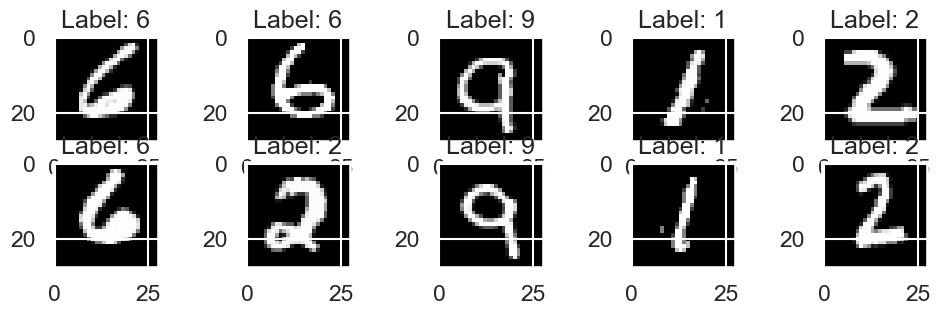

In [15]:
# set autoreload
%load_ext autoreload
%autoreload 2

from models import MNISTConvNet, MNISTFederatedServer, get_mnist_dataloader, init_clients, MNISTConvNetTrainer
import matplotlib.pyplot as plt
import seaborn as sns

# firstly, we create the dataloader for the MNIST dataset
train, val, test = get_mnist_dataloader(64)

# print some sample images from the training set with matplotlib
# just some code to show the usual images we all know well!
fig, axs = plt.subplots(2, 5, figsize=(12, 3))
for i, ax in enumerate(axs.flat):
    ax.imshow(train.dataset[i][0].squeeze(), cmap='gray')
    ax.set_title(f'Label: {train.dataset[i][1]}')

In [3]:
trainer = MNISTConvNetTrainer(
    MNISTConvNet(), 
    train,          # training set
    val,            # using validation set
    device='mps',   # training using Apple's Metal Performance Shaders, you can also use 'cuda' or 'cpu'
    weight_decay=1e-5,
    lr=0.01
)   

# training the model on the whole training sety (50000 samples), for 10 epochs.
# Optimizer is Adam, with a learning rate of 0.001 and a weight decay of 0.0001
# since this is a very simple task, we can safely ignore a proper model selection procedure.
trainer.train(16)
loss, accuracy = trainer.test(test)

print(f'Test loss: {loss:.4f}, accuracy: {accuracy:.4f}')

Model created and moved to mps


  6%|██▊                                         | 1/16 [00:05<01:29,  5.99s/it]

Epoch 1, Loss: 1.9405596638884386, Accuracy: 0.35716, Val Loss: 0.44362732768058777, Val Acc: 0.8711


 12%|█████▌                                      | 2/16 [00:11<01:23,  5.98s/it]

Epoch 2, Loss: 0.27335481913498294, Accuracy: 0.91702, Val Loss: 0.17440347373485565, Val Acc: 0.9477


 19%|████████▎                                   | 3/16 [00:17<01:17,  5.97s/it]

Epoch 3, Loss: 0.16551537211755735, Accuracy: 0.9495, Val Loss: 0.1500484198331833, Val Acc: 0.9542


 25%|███████████                                 | 4/16 [00:23<01:11,  5.98s/it]

Epoch 4, Loss: 0.1331484581122313, Accuracy: 0.95894, Val Loss: 0.12709951400756836, Val Acc: 0.9601


 31%|█████████████▊                              | 5/16 [00:29<01:05,  5.98s/it]

Epoch 5, Loss: 0.1101518206469848, Accuracy: 0.965, Val Loss: 0.08778044581413269, Val Acc: 0.9726


 38%|████████████████▌                           | 6/16 [00:35<00:59,  5.98s/it]

Epoch 6, Loss: 0.09784905068919329, Accuracy: 0.96948, Val Loss: 0.1044091060757637, Val Acc: 0.967


 44%|███████████████████▎                        | 7/16 [00:41<00:53,  5.98s/it]

Epoch 7, Loss: 0.08905594135203478, Accuracy: 0.97212, Val Loss: 0.08353012055158615, Val Acc: 0.9745


 50%|██████████████████████                      | 8/16 [00:47<00:47,  5.98s/it]

Epoch 8, Loss: 0.0796919374010952, Accuracy: 0.97514, Val Loss: 0.08617401868104935, Val Acc: 0.9721


 56%|████████████████████████▊                   | 9/16 [00:53<00:41,  5.97s/it]

Epoch 9, Loss: 0.07447032620558691, Accuracy: 0.97694, Val Loss: 0.06579943001270294, Val Acc: 0.9788


 62%|██████████████████████████▉                | 10/16 [00:59<00:35,  5.98s/it]

Epoch 10, Loss: 0.06979582982573687, Accuracy: 0.97824, Val Loss: 0.061001911759376526, Val Acc: 0.9807


 69%|█████████████████████████████▌             | 11/16 [01:05<00:29,  5.97s/it]

Epoch 11, Loss: 0.06546405416346439, Accuracy: 0.97926, Val Loss: 0.06383074820041656, Val Acc: 0.9798


 75%|████████████████████████████████▎          | 12/16 [01:11<00:23,  5.96s/it]

Epoch 12, Loss: 0.06011841846498973, Accuracy: 0.98106, Val Loss: 0.057774920016527176, Val Acc: 0.9811


 81%|██████████████████████████████████▉        | 13/16 [01:17<00:17,  5.96s/it]

Epoch 13, Loss: 0.058601386570002495, Accuracy: 0.9816, Val Loss: 0.05636875331401825, Val Acc: 0.9823


 88%|█████████████████████████████████████▋     | 14/16 [01:23<00:11,  5.95s/it]

Epoch 14, Loss: 0.05600207090935172, Accuracy: 0.98214, Val Loss: 0.07536415010690689, Val Acc: 0.9767


 94%|████████████████████████████████████████▎  | 15/16 [01:29<00:05,  5.96s/it]

Epoch 15, Loss: 0.05235358287626163, Accuracy: 0.98344, Val Loss: 0.05204688385128975, Val Acc: 0.9837


100%|███████████████████████████████████████████| 16/16 [01:35<00:00,  5.97s/it]

Epoch 16, Loss: 0.050090836584055914, Accuracy: 0.98406, Val Loss: 0.0516400970518589, Val Acc: 0.9832


Test loss: 0.0415, accuracy: 0.9859


### We now have a solid baseline model that we will use to compare the performance of the Federated Learning approach.
Without model selelction and further tuning, we reached a CE loss of $0.0415$ and an accuracy of $98.59%$ on the blind test set.

Let's now test the Federated Learning approach. We will first test it on 10 clients, although the number of clients can be easily increased by changing the `n_clients` parameter.

We will train the same model architecture on each client, and according to the algorithm, we will average the weights of the models at the end of each round.  

Each client will draw a subset of 512 data points from the training set, and we will train the model for 5 epochs on each client. We will run 64 rounds of training (64 global updates), with 10 jobs running in parallel (my machine has 10 cores...): in this case, we are assuming that the data is IID across the clients; we will further release this assumption. These parameers reflect those of the original FedAvg paper.

> Note: with this simple setup, we will not implement any advanced techniques to improve the performance of the model, such as learning rate scheduling, early stopping, or data augmentation. The goal is to provide a simple implementation of the Federated Learning algorithm in plain torch. 

> Note: in the spirit of FedAvg, the server is not aware of the data distribution on the clients.

In [5]:
model5e10c  = MNISTConvNet()
server5e10c = MNISTFederatedServer(model=model5e10c, test_loader=val)


# we first create 10 clients
clients = init_clients(
    num_clients=10, 
    local_epochs=5, 
    lr=1e-2, 
    train_dataset=train, 
    n_samples=512, 
    device='mps', 
    weight_decay=1e-6, 
    sample_method='iid'
)

loss_5, acc_5 = server5e10c.start_train(clients, n_rounds=64, n_jobs=10)

> Client 0 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 1 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 2 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 3 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 4 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 5 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 6 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 7 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 8 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 9 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9804.36it/s]


Aggregating 10 local states

Round 0, Test Loss: 2.2974913120269775, Test Acc: 0.1152


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11441.09it/s]


Aggregating 10 local states

Round 1, Test Loss: 2.2867021560668945, Test Acc: 0.1488


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10824.01it/s]


Aggregating 10 local states

Round 2, Test Loss: 2.2705745697021484, Test Acc: 0.1862


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9589.17it/s]


Aggregating 10 local states

Round 3, Test Loss: 2.241772413253784, Test Acc: 0.3219


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10680.68it/s]


Aggregating 10 local states

Round 4, Test Loss: 2.169515371322632, Test Acc: 0.5144


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12516.57it/s]


Aggregating 10 local states

Round 5, Test Loss: 1.89057195186615, Test Acc: 0.5904


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8297.34it/s]


Aggregating 10 local states

Round 6, Test Loss: 1.1082104444503784, Test Acc: 0.7428


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9991.20it/s]


Aggregating 10 local states

Round 7, Test Loss: 0.6721987128257751, Test Acc: 0.8273


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 919.20it/s]


Aggregating 10 local states

Round 8, Test Loss: 0.4894760549068451, Test Acc: 0.8745


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14141.28it/s]


Aggregating 10 local states

Round 9, Test Loss: 0.39170897006988525, Test Acc: 0.8908


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9679.91it/s]


Aggregating 10 local states

Round 10, Test Loss: 0.33500614762306213, Test Acc: 0.907


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11891.99it/s]


Aggregating 10 local states

Round 11, Test Loss: 0.2866800129413605, Test Acc: 0.9187


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11778.44it/s]


Aggregating 10 local states

Round 12, Test Loss: 0.2583601772785187, Test Acc: 0.9227


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9569.48it/s]


Aggregating 10 local states

Round 13, Test Loss: 0.23203951120376587, Test Acc: 0.9328


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9108.15it/s]


Aggregating 10 local states

Round 14, Test Loss: 0.21610255539417267, Test Acc: 0.9391


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9560.76it/s]


Aggregating 10 local states

Round 15, Test Loss: 0.1958976536989212, Test Acc: 0.941


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10287.72it/s]


Aggregating 10 local states

Round 16, Test Loss: 0.18465234339237213, Test Acc: 0.9463


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8598.41it/s]


Aggregating 10 local states

Round 17, Test Loss: 0.17622481286525726, Test Acc: 0.9476


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12146.84it/s]


Aggregating 10 local states

Round 18, Test Loss: 0.16659490764141083, Test Acc: 0.9506


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8251.63it/s]


Aggregating 10 local states

Round 19, Test Loss: 0.15896350145339966, Test Acc: 0.9527


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12303.62it/s]


Aggregating 10 local states

Round 20, Test Loss: 0.15331336855888367, Test Acc: 0.9533


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14498.11it/s]


Aggregating 10 local states

Round 21, Test Loss: 0.1485227644443512, Test Acc: 0.9558


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12449.70it/s]


Aggregating 10 local states

Round 22, Test Loss: 0.1419733315706253, Test Acc: 0.957


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10962.63it/s]


Aggregating 10 local states

Round 23, Test Loss: 0.13693000376224518, Test Acc: 0.9585


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14488.10it/s]


Aggregating 10 local states

Round 24, Test Loss: 0.13262419402599335, Test Acc: 0.9613


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15358.13it/s]


Aggregating 10 local states

Round 25, Test Loss: 0.12916429340839386, Test Acc: 0.9619


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9670.98it/s]


Aggregating 10 local states

Round 26, Test Loss: 0.12651760876178741, Test Acc: 0.9636


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8511.17it/s]


Aggregating 10 local states

Round 27, Test Loss: 0.12266874313354492, Test Acc: 0.9638


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12957.38it/s]


Aggregating 10 local states

Round 28, Test Loss: 0.12183897942304611, Test Acc: 0.9652


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8944.99it/s]


Aggregating 10 local states

Round 29, Test Loss: 0.1194639503955841, Test Acc: 0.9653


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14388.69it/s]


Aggregating 10 local states

Round 30, Test Loss: 0.11464908719062805, Test Acc: 0.9672


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9776.93it/s]


Aggregating 10 local states

Round 31, Test Loss: 0.11227893084287643, Test Acc: 0.968


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10672.53it/s]


Aggregating 10 local states

Round 32, Test Loss: 0.11116953194141388, Test Acc: 0.9669


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12271.22it/s]


Aggregating 10 local states

Round 33, Test Loss: 0.10987190902233124, Test Acc: 0.9685


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12885.73it/s]


Aggregating 10 local states

Round 34, Test Loss: 0.10694412887096405, Test Acc: 0.9696


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13298.36it/s]


Aggregating 10 local states

Round 35, Test Loss: 0.10675549507141113, Test Acc: 0.9681


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9979.31it/s]


Aggregating 10 local states

Round 36, Test Loss: 0.10298805683851242, Test Acc: 0.9719


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11469.25it/s]


Aggregating 10 local states

Round 37, Test Loss: 0.10058972239494324, Test Acc: 0.9718


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10942.61it/s]


Aggregating 10 local states

Round 38, Test Loss: 0.10108067095279694, Test Acc: 0.9716


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11348.23it/s]


Aggregating 10 local states

Round 39, Test Loss: 0.09989704191684723, Test Acc: 0.9713


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13353.40it/s]


Aggregating 10 local states

Round 40, Test Loss: 0.09971477091312408, Test Acc: 0.9716


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9589.17it/s]


Aggregating 10 local states

Round 41, Test Loss: 0.09422710537910461, Test Acc: 0.973


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10384.51it/s]


Aggregating 10 local states

Round 42, Test Loss: 0.09372596442699432, Test Acc: 0.9732


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9149.88it/s]


Aggregating 10 local states

Round 43, Test Loss: 0.09300023317337036, Test Acc: 0.9729


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11002.90it/s]


Aggregating 10 local states

Round 44, Test Loss: 0.0924263745546341, Test Acc: 0.9735


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12953.38it/s]


Aggregating 10 local states

Round 45, Test Loss: 0.09182777255773544, Test Acc: 0.9743


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10798.93it/s]


Aggregating 10 local states

Round 46, Test Loss: 0.09093943983316422, Test Acc: 0.9743


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13037.94it/s]


Aggregating 10 local states

Round 47, Test Loss: 0.08941035717725754, Test Acc: 0.9745


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11000.01it/s]


Aggregating 10 local states

Round 48, Test Loss: 0.08904704451560974, Test Acc: 0.9746


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12300.01it/s]


Aggregating 10 local states

Round 49, Test Loss: 0.0871208906173706, Test Acc: 0.9749


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 992.17it/s]


Aggregating 10 local states

Round 50, Test Loss: 0.08682696521282196, Test Acc: 0.9747


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10451.79it/s]


Aggregating 10 local states

Round 51, Test Loss: 0.08619914203882217, Test Acc: 0.9752


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13181.35it/s]


Aggregating 10 local states

Round 52, Test Loss: 0.08474688977003098, Test Acc: 0.9746


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12889.69it/s]


Aggregating 10 local states

Round 53, Test Loss: 0.08362686634063721, Test Acc: 0.9752


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10559.68it/s]


Aggregating 10 local states

Round 54, Test Loss: 0.0840107873082161, Test Acc: 0.9756


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10798.93it/s]


Aggregating 10 local states

Round 55, Test Loss: 0.08372247219085693, Test Acc: 0.9752


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11113.68it/s]


Aggregating 10 local states

Round 56, Test Loss: 0.08269309997558594, Test Acc: 0.9758


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12546.53it/s]


Aggregating 10 local states

Round 57, Test Loss: 0.08128082007169724, Test Acc: 0.9757


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11172.89it/s]


Aggregating 10 local states

Round 58, Test Loss: 0.08338136225938797, Test Acc: 0.9755


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11311.50it/s]


Aggregating 10 local states

Round 59, Test Loss: 0.08128601312637329, Test Acc: 0.9759


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10718.90it/s]


Aggregating 10 local states

Round 60, Test Loss: 0.08021310716867447, Test Acc: 0.9767


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11765.23it/s]


Aggregating 10 local states

Round 61, Test Loss: 0.08070648461580276, Test Acc: 0.9758


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12328.94it/s]


Aggregating 10 local states

Round 62, Test Loss: 0.07934726774692535, Test Acc: 0.9758


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 967.19it/s]


Aggregating 10 local states

Round 63, Test Loss: 0.07800551503896713, Test Acc: 0.9762


In [7]:
# test the model on the test set
loss, accuracy = server5e10c.test()
print(f'Test loss: {loss:.4f}, accuracy: {accuracy:.4f}')

Test loss: 0.0780, accuracy: 0.9762


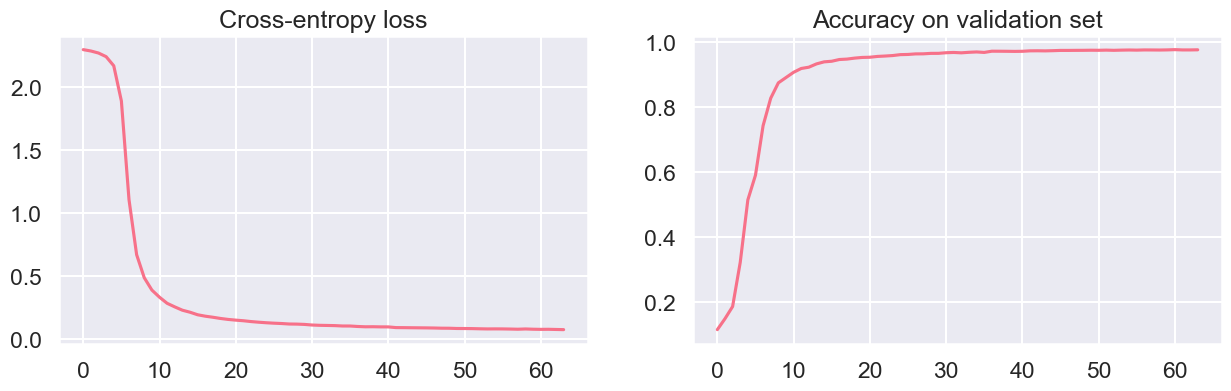

In [16]:
# plot history with seaborn
sns.set_palette('husl')
sns.set_context('talk')

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(loss_5)
axs[0].set_title('Cross-entropy loss')
axs[1].plot(acc_5)
axs[1].set_title('Accuracy on validation set')
plt.show()

### It works! The model trained with Federated Learning reached a CE loss of $0.0780$ and an accuracy of $97.62\%$ on the blind test set.
(I think that there is still some margin for improvement, but the results are already quite good!)


### Now, let's test federated learning with many clients, each one sampling very few data points from the training set. Again, the distribution is iid across the clients.
This expetiment aims to simulate a more realistic scenario where the data samples are few and distributed across many clients. We will use 128 clients, each one drawing 32 data points from the training set. We will train the model for 5 epochs on each client, and we will run 64 rounds of training with 16 jobs running in parallel.

In [20]:
model5e128c  = MNISTConvNet()
server = MNISTFederatedServer(model=model5e128c, test_loader=val)

clients = init_clients(
   num_clients=128,
   local_epochs=5,
   lr=1e-2,
   train_dataset=train,
   n_samples=32,
   device='mps',
   weight_decay=1e-10,
   sample_method='iid'
)

loss5e128c, acc_5e128c = server.start_train(clients, n_rounds=128, n_jobs=10)

> Client 0 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 1 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 2 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 3 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 4 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 5 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 6 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 7 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 8 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 9 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 10 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 11 created, lr: 0.01, epochs: 5, 

100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.76it/s]


Aggregating 128 local states

Round 0, Test Loss: 2.304062843322754, Test Acc: 0.096


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.73it/s]


Aggregating 128 local states

Round 1, Test Loss: 2.302790641784668, Test Acc: 0.0974


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.58it/s]


Aggregating 128 local states

Round 2, Test Loss: 2.3015871047973633, Test Acc: 0.0983


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.85it/s]


Aggregating 128 local states

Round 3, Test Loss: 2.3005239963531494, Test Acc: 0.099


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.58it/s]


Aggregating 128 local states

Round 4, Test Loss: 2.299320936203003, Test Acc: 0.1009


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.73it/s]


Aggregating 128 local states

Round 5, Test Loss: 2.29826021194458, Test Acc: 0.1036


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.72it/s]


Aggregating 128 local states

Round 6, Test Loss: 2.2972590923309326, Test Acc: 0.1048


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.36it/s]


Aggregating 128 local states

Round 7, Test Loss: 2.2962660789489746, Test Acc: 0.1061


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.43it/s]


Aggregating 128 local states

Round 8, Test Loss: 2.295254945755005, Test Acc: 0.1087


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.24it/s]


Aggregating 128 local states

Round 9, Test Loss: 2.2942259311676025, Test Acc: 0.1115


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.10it/s]


Aggregating 128 local states

Round 10, Test Loss: 2.2931089401245117, Test Acc: 0.1122


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.66it/s]


Aggregating 128 local states

Round 11, Test Loss: 2.291980028152466, Test Acc: 0.1154


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.93it/s]


Aggregating 128 local states

Round 12, Test Loss: 2.2908072471618652, Test Acc: 0.1179


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.18it/s]


Aggregating 128 local states

Round 13, Test Loss: 2.289490222930908, Test Acc: 0.1218


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.90it/s]


Aggregating 128 local states

Round 14, Test Loss: 2.28820538520813, Test Acc: 0.1286


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.04it/s]


Aggregating 128 local states

Round 15, Test Loss: 2.286795139312744, Test Acc: 0.1304


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.63it/s]


Aggregating 128 local states

Round 16, Test Loss: 2.285417318344116, Test Acc: 0.1402


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.46it/s]


Aggregating 128 local states

Round 17, Test Loss: 2.2838668823242188, Test Acc: 0.155


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.94it/s]


Aggregating 128 local states

Round 18, Test Loss: 2.2823686599731445, Test Acc: 0.1656


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.18it/s]


Aggregating 128 local states

Round 19, Test Loss: 2.280785083770752, Test Acc: 0.1746


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.00it/s]


Aggregating 128 local states

Round 20, Test Loss: 2.2790896892547607, Test Acc: 0.1903


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.79it/s]


Aggregating 128 local states

Round 21, Test Loss: 2.2775158882141113, Test Acc: 0.1982


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.95it/s]


Aggregating 128 local states

Round 22, Test Loss: 2.27579665184021, Test Acc: 0.1947


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.75it/s]


Aggregating 128 local states

Round 23, Test Loss: 2.274035692214966, Test Acc: 0.1992


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.69it/s]


Aggregating 128 local states

Round 24, Test Loss: 2.2720370292663574, Test Acc: 0.2004


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.87it/s]


Aggregating 128 local states

Round 25, Test Loss: 2.270007848739624, Test Acc: 0.2083


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.40it/s]


Aggregating 128 local states

Round 26, Test Loss: 2.267939329147339, Test Acc: 0.2136


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.55it/s]


Aggregating 128 local states

Round 27, Test Loss: 2.2656781673431396, Test Acc: 0.2192


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.31it/s]


Aggregating 128 local states

Round 28, Test Loss: 2.26332950592041, Test Acc: 0.2142


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.66it/s]


Aggregating 128 local states

Round 29, Test Loss: 2.2606897354125977, Test Acc: 0.2163


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.66it/s]


Aggregating 128 local states

Round 30, Test Loss: 2.2579147815704346, Test Acc: 0.2184


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.08it/s]


Aggregating 128 local states

Round 31, Test Loss: 2.254995584487915, Test Acc: 0.2191


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.21it/s]


Aggregating 128 local states

Round 32, Test Loss: 2.2518527507781982, Test Acc: 0.2379


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.98it/s]


Aggregating 128 local states

Round 33, Test Loss: 2.248610496520996, Test Acc: 0.2384


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.26it/s]


Aggregating 128 local states

Round 34, Test Loss: 2.245014190673828, Test Acc: 0.2483


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.51it/s]


Aggregating 128 local states

Round 35, Test Loss: 2.2411999702453613, Test Acc: 0.2548


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.57it/s]


Aggregating 128 local states

Round 36, Test Loss: 2.2369658946990967, Test Acc: 0.2804


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.49it/s]


Aggregating 128 local states

Round 37, Test Loss: 2.2325592041015625, Test Acc: 0.2874


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.93it/s]


Aggregating 128 local states

Round 38, Test Loss: 2.22733211517334, Test Acc: 0.2931


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.96it/s]


Aggregating 128 local states

Round 39, Test Loss: 2.221963882446289, Test Acc: 0.2961


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.24it/s]


Aggregating 128 local states

Round 40, Test Loss: 2.2161378860473633, Test Acc: 0.3122


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.65it/s]


Aggregating 128 local states

Round 41, Test Loss: 2.209613084793091, Test Acc: 0.3106


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.09it/s]


Aggregating 128 local states

Round 42, Test Loss: 2.2027792930603027, Test Acc: 0.3399


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.01it/s]


Aggregating 128 local states

Round 43, Test Loss: 2.1951487064361572, Test Acc: 0.3258


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.62it/s]


Aggregating 128 local states

Round 44, Test Loss: 2.1864101886749268, Test Acc: 0.3487


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.99it/s]


Aggregating 128 local states

Round 45, Test Loss: 2.17632794380188, Test Acc: 0.374


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.22it/s]


Aggregating 128 local states

Round 46, Test Loss: 2.165963649749756, Test Acc: 0.4222


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.82it/s]


Aggregating 128 local states

Round 47, Test Loss: 2.154331684112549, Test Acc: 0.4385


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.50it/s]


Aggregating 128 local states

Round 48, Test Loss: 2.141397476196289, Test Acc: 0.4644


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.52it/s]


Aggregating 128 local states

Round 49, Test Loss: 2.1265008449554443, Test Acc: 0.4806


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.13it/s]


Aggregating 128 local states

Round 50, Test Loss: 2.110175132751465, Test Acc: 0.4708


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.50it/s]


Aggregating 128 local states

Round 51, Test Loss: 2.091879367828369, Test Acc: 0.4743


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.96it/s]


Aggregating 128 local states

Round 52, Test Loss: 2.0711464881896973, Test Acc: 0.5288


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.75it/s]


Aggregating 128 local states

Round 53, Test Loss: 2.0475480556488037, Test Acc: 0.5307


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.68it/s]


Aggregating 128 local states

Round 54, Test Loss: 2.0209403038024902, Test Acc: 0.5793


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.59it/s]


Aggregating 128 local states

Round 55, Test Loss: 1.9908117055892944, Test Acc: 0.5676


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.85it/s]


Aggregating 128 local states

Round 56, Test Loss: 1.956808090209961, Test Acc: 0.575


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.84it/s]


Aggregating 128 local states

Round 57, Test Loss: 1.918311595916748, Test Acc: 0.5843


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.32it/s]


Aggregating 128 local states

Round 58, Test Loss: 1.8731153011322021, Test Acc: 0.6292


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.71it/s]


Aggregating 128 local states

Round 59, Test Loss: 1.8209105730056763, Test Acc: 0.6479


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.32it/s]


Aggregating 128 local states

Round 60, Test Loss: 1.764423131942749, Test Acc: 0.6542


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.01it/s]


Aggregating 128 local states

Round 61, Test Loss: 1.7008848190307617, Test Acc: 0.6597


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.90it/s]


Aggregating 128 local states

Round 62, Test Loss: 1.6316920518875122, Test Acc: 0.6743


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.60it/s]


Aggregating 128 local states

Round 63, Test Loss: 1.5575963258743286, Test Acc: 0.6832


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.48it/s]


Aggregating 128 local states

Round 64, Test Loss: 1.4830219745635986, Test Acc: 0.7011


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.57it/s]


Aggregating 128 local states

Round 65, Test Loss: 1.4077813625335693, Test Acc: 0.7112


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.50it/s]


Aggregating 128 local states

Round 66, Test Loss: 1.330188274383545, Test Acc: 0.7199


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.98it/s]


Aggregating 128 local states

Round 67, Test Loss: 1.2591444253921509, Test Acc: 0.7239


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.61it/s]


Aggregating 128 local states

Round 68, Test Loss: 1.192244291305542, Test Acc: 0.7339


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.58it/s]


Aggregating 128 local states

Round 69, Test Loss: 1.1313468217849731, Test Acc: 0.7329


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.50it/s]


Aggregating 128 local states

Round 70, Test Loss: 1.0759016275405884, Test Acc: 0.7474


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.14it/s]


Aggregating 128 local states

Round 71, Test Loss: 1.0297871828079224, Test Acc: 0.7539


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.84it/s]


Aggregating 128 local states

Round 72, Test Loss: 0.9927557706832886, Test Acc: 0.7475


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.09it/s]


Aggregating 128 local states

Round 73, Test Loss: 0.9689432978630066, Test Acc: 0.7468


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.64it/s]


Aggregating 128 local states

Round 74, Test Loss: 0.942797064781189, Test Acc: 0.7447


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.54it/s]


Aggregating 128 local states

Round 75, Test Loss: 0.9378873109817505, Test Acc: 0.7465


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.73it/s]


Aggregating 128 local states

Round 76, Test Loss: 0.903792142868042, Test Acc: 0.7472


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.85it/s]


Aggregating 128 local states

Round 77, Test Loss: 0.8555908203125, Test Acc: 0.767


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.91it/s]


Aggregating 128 local states

Round 78, Test Loss: 0.8124154806137085, Test Acc: 0.7798


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.99it/s]


Aggregating 128 local states

Round 79, Test Loss: 0.7945777177810669, Test Acc: 0.7845


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.27it/s]


Aggregating 128 local states

Round 80, Test Loss: 0.7641902565956116, Test Acc: 0.7894


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.00it/s]


Aggregating 128 local states

Round 81, Test Loss: 0.7416940331459045, Test Acc: 0.7974


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.11it/s]


Aggregating 128 local states

Round 82, Test Loss: 0.7252471446990967, Test Acc: 0.7969


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.48it/s]


Aggregating 128 local states

Round 83, Test Loss: 0.7048944234848022, Test Acc: 0.8045


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.21it/s]


Aggregating 128 local states

Round 84, Test Loss: 0.7019215226173401, Test Acc: 0.794


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.76it/s]


Aggregating 128 local states

Round 85, Test Loss: 0.6867209672927856, Test Acc: 0.8065


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.97it/s]


Aggregating 128 local states

Round 86, Test Loss: 0.6703742146492004, Test Acc: 0.8052


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.00it/s]


Aggregating 128 local states

Round 87, Test Loss: 0.6528905630111694, Test Acc: 0.8118


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.64it/s]


Aggregating 128 local states

Round 88, Test Loss: 0.6420109868049622, Test Acc: 0.8124


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.79it/s]


Aggregating 128 local states

Round 89, Test Loss: 0.6310867667198181, Test Acc: 0.817


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.86it/s]


Aggregating 128 local states

Round 90, Test Loss: 0.617955207824707, Test Acc: 0.819


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.30it/s]


Aggregating 128 local states

Round 91, Test Loss: 0.6109843254089355, Test Acc: 0.8231


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.48it/s]


Aggregating 128 local states

Round 92, Test Loss: 0.5978999733924866, Test Acc: 0.8286


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.43it/s]


Aggregating 128 local states

Round 93, Test Loss: 0.5890021920204163, Test Acc: 0.8257


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.12it/s]


Aggregating 128 local states

Round 94, Test Loss: 0.5763302445411682, Test Acc: 0.8335


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.70it/s]


Aggregating 128 local states

Round 95, Test Loss: 0.5684643983840942, Test Acc: 0.832


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.32it/s]


Aggregating 128 local states

Round 96, Test Loss: 0.5598760843276978, Test Acc: 0.8359


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.64it/s]


Aggregating 128 local states

Round 97, Test Loss: 0.5488477349281311, Test Acc: 0.8386


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.60it/s]


Aggregating 128 local states

Round 98, Test Loss: 0.542689859867096, Test Acc: 0.8405


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.60it/s]


Aggregating 128 local states

Round 99, Test Loss: 0.5361011624336243, Test Acc: 0.8417


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.48it/s]


Aggregating 128 local states

Round 100, Test Loss: 0.5301676392555237, Test Acc: 0.8396


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.10it/s]


Aggregating 128 local states

Round 101, Test Loss: 0.5227909684181213, Test Acc: 0.8448


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.35it/s]


Aggregating 128 local states

Round 102, Test Loss: 0.5153524279594421, Test Acc: 0.8451


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.80it/s]


Aggregating 128 local states

Round 103, Test Loss: 0.5073056817054749, Test Acc: 0.8488


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.62it/s]


Aggregating 128 local states

Round 104, Test Loss: 0.4994281232357025, Test Acc: 0.853


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.07it/s]


Aggregating 128 local states

Round 105, Test Loss: 0.49776098132133484, Test Acc: 0.8488


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.31it/s]


Aggregating 128 local states

Round 106, Test Loss: 0.4928385317325592, Test Acc: 0.8498


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.05it/s]


Aggregating 128 local states

Round 107, Test Loss: 0.4863804578781128, Test Acc: 0.855


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.90it/s]


Aggregating 128 local states

Round 108, Test Loss: 0.4796847701072693, Test Acc: 0.8549


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.30it/s]


Aggregating 128 local states

Round 109, Test Loss: 0.4743649363517761, Test Acc: 0.8578


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.70it/s]


Aggregating 128 local states

Round 110, Test Loss: 0.4658496677875519, Test Acc: 0.8588


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.88it/s]


Aggregating 128 local states

Round 111, Test Loss: 0.46001356840133667, Test Acc: 0.8598


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.76it/s]


Aggregating 128 local states

Round 112, Test Loss: 0.460229754447937, Test Acc: 0.8616


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.93it/s]


Aggregating 128 local states

Round 113, Test Loss: 0.45182937383651733, Test Acc: 0.8626


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.76it/s]


Aggregating 128 local states

Round 114, Test Loss: 0.44589489698410034, Test Acc: 0.8646


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.97it/s]


Aggregating 128 local states

Round 115, Test Loss: 0.44026875495910645, Test Acc: 0.8662


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.40it/s]


Aggregating 128 local states

Round 116, Test Loss: 0.4360124170780182, Test Acc: 0.867


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.72it/s]


Aggregating 128 local states

Round 117, Test Loss: 0.43504658341407776, Test Acc: 0.8684


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.75it/s]


Aggregating 128 local states

Round 118, Test Loss: 0.43013301491737366, Test Acc: 0.8667


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.76it/s]


Aggregating 128 local states

Round 119, Test Loss: 0.4266943037509918, Test Acc: 0.8709


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.31it/s]


Aggregating 128 local states

Round 120, Test Loss: 0.4223155081272125, Test Acc: 0.8689


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.45it/s]


Aggregating 128 local states

Round 121, Test Loss: 0.41491222381591797, Test Acc: 0.8747


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.23it/s]


Aggregating 128 local states

Round 122, Test Loss: 0.41136741638183594, Test Acc: 0.8718


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.25it/s]


Aggregating 128 local states

Round 123, Test Loss: 0.4129917025566101, Test Acc: 0.8722


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.55it/s]


Aggregating 128 local states

Round 124, Test Loss: 0.4076712429523468, Test Acc: 0.8741


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.75it/s]


Aggregating 128 local states

Round 125, Test Loss: 0.4036221206188202, Test Acc: 0.8755


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.70it/s]


Aggregating 128 local states

Round 126, Test Loss: 0.40090861916542053, Test Acc: 0.8746


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.47it/s]


Aggregating 128 local states

Round 127, Test Loss: 0.39836201071739197, Test Acc: 0.8767


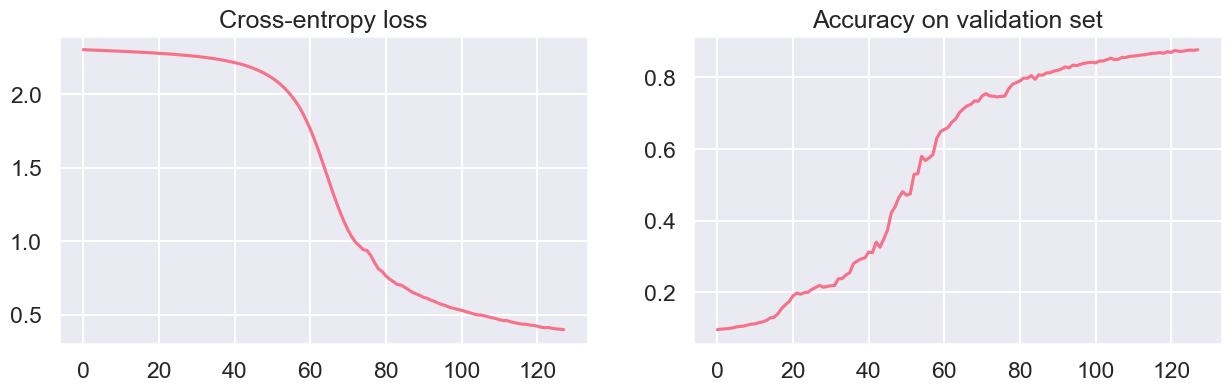

In [21]:
# plot history with seaborn
sns.set_palette('husl')
sns.set_context('talk')

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(loss5e128c)
axs[0].set_title('Cross-entropy loss')
 
axs[1].plot(acc_5e128c)
axs[1].set_title('Accuracy on validation set')
plt.show()

In [23]:
# save history
import pickle

with open('../histories/loss5e128c.pkl', 'wb') as f:
    pickle.dump(loss5e128c, f)

with open('../histories/acc5e128c.pkl', 'wb') as f:
    pickle.dump(acc_5e128c, f)

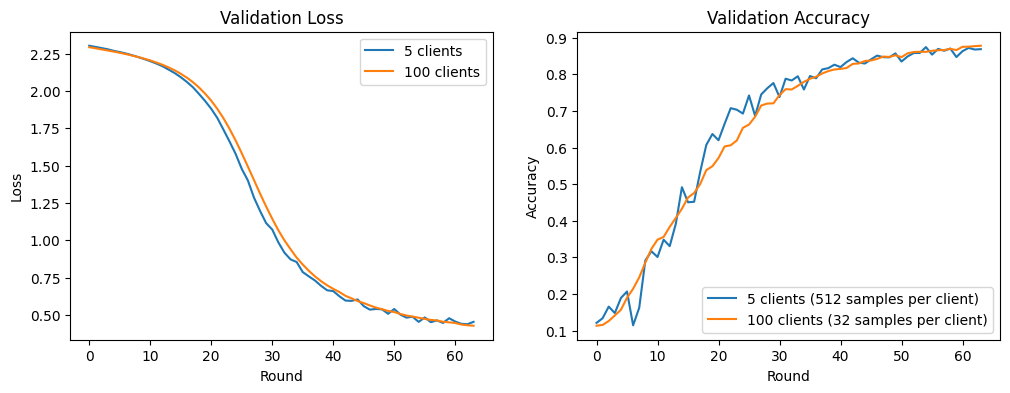

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(loss_5, label='5 clients')
axs[0].plot(loss_100, label='100 clients')
axs[0].set_title('Validation Loss')
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(acc_5, label='5 clients (512 samples per client)')
axs[1].plot(acc_100, label='100 clients (32 samples per client)')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Round')

## Testing fedavg on MNIST dataset with different numbers of epochs per client

In [33]:
model5e  = MNISTConvNet()
server5e = MNISTFederatedServer(model=model5e, test_loader=val)

clients = init_clients(
   num_clients=5,
   local_epochs=5,
   lr=1e-2,
   train_dataset=train,
   n_samples=256,
   device='mps',
   weight_decay=1e-8,
   sample_method='iid'
)

loss_5e, acc_5e = server5e.start_train(clients, n_rounds=64, n_jobs=8)


model10e  = MNISTConvNet()
server10e = MNISTFederatedServer(model=model10e, test_loader=val)

clients = init_clients(
   num_clients=10,
   local_epochs=5,
   lr=1e-2,
   train_dataset=train,
   n_samples=256,
   device='mps',
   weight_decay=1e-8
)

loss_10e, acc_10e = server10e.start_train(clients, n_rounds=64, n_jobs=8)

model20e  = MNISTConvNet()
server20e = MNISTFederatedServer(model=model20e, test_loader=val)
clients = init_clients(
    num_clients=20,
    local_epochs=5,
    lr=1e-2,
    train_dataset=train,
    n_samples=256,
    device='mps',
    weight_decay=1e-8
)

loss_20e, acc_20e = server20e.start_train(clients, n_rounds=64, n_jobs=8)

> Client 0 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 1 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 2 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 3 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 4 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7727.16it/s]


Aggregating 5 local states

Round 0, Test Loss: 2.236664295196533, Test Acc: 0.2248



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9976.94it/s]


Aggregating 5 local states

Round 1, Test Loss: 2.09131121635437, Test Acc: 0.2945



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8958.36it/s]


Aggregating 5 local states

Round 2, Test Loss: 1.6785376071929932, Test Acc: 0.6322



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 5035.18it/s]


Aggregating 5 local states

Round 3, Test Loss: 1.0279768705368042, Test Acc: 0.7783



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7925.74it/s]


Aggregating 5 local states

Round 4, Test Loss: 0.6927943825721741, Test Acc: 0.8239



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7667.83it/s]


Aggregating 5 local states

Round 5, Test Loss: 0.5788375735282898, Test Acc: 0.8238



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6159.04it/s]


Aggregating 5 local states

Round 6, Test Loss: 0.48344752192497253, Test Acc: 0.8641



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6758.47it/s]


Aggregating 5 local states

Round 7, Test Loss: 0.4532080590724945, Test Acc: 0.8641



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 5981.61it/s]


Aggregating 5 local states

Round 8, Test Loss: 0.4168792963027954, Test Acc: 0.8767



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7373.95it/s]


Aggregating 5 local states

Round 9, Test Loss: 0.3909553587436676, Test Acc: 0.8879



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7226.57it/s]


Aggregating 5 local states

Round 10, Test Loss: 0.38315820693969727, Test Acc: 0.8794



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6655.51it/s]


Aggregating 5 local states

Round 11, Test Loss: 0.3715273141860962, Test Acc: 0.888



100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13671.13it/s]


Aggregating 5 local states

Round 12, Test Loss: 0.3431543707847595, Test Acc: 0.8994



100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11441.09it/s]


Aggregating 5 local states

Round 13, Test Loss: 0.3457876741886139, Test Acc: 0.8952



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 5681.80it/s]


Aggregating 5 local states

Round 14, Test Loss: 0.3208348751068115, Test Acc: 0.9056



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9222.30it/s]


Aggregating 5 local states

Round 15, Test Loss: 0.31060412526130676, Test Acc: 0.9045



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 5371.80it/s]


Aggregating 5 local states

Round 16, Test Loss: 0.29894474148750305, Test Acc: 0.91



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8172.84it/s]


Aggregating 5 local states

Round 17, Test Loss: 0.2923809587955475, Test Acc: 0.9123



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8727.22it/s]


Aggregating 5 local states

Round 18, Test Loss: 0.28323644399642944, Test Acc: 0.9152



100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13366.17it/s]


Aggregating 5 local states

Round 19, Test Loss: 0.27664682269096375, Test Acc: 0.9166



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7787.42it/s]


Aggregating 5 local states

Round 20, Test Loss: 0.2628509998321533, Test Acc: 0.9217



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7752.87it/s]


Aggregating 5 local states

Round 21, Test Loss: 0.2553616464138031, Test Acc: 0.9253



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8001.34it/s]


Aggregating 5 local states

Round 22, Test Loss: 0.2569921314716339, Test Acc: 0.9212



100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10645.44it/s]


Aggregating 5 local states

Round 23, Test Loss: 0.24787674844264984, Test Acc: 0.927



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7484.48it/s]


Aggregating 5 local states

Round 24, Test Loss: 0.24222375452518463, Test Acc: 0.9294



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6484.70it/s]


Aggregating 5 local states

Round 25, Test Loss: 0.2380807250738144, Test Acc: 0.9264



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8253.25it/s]


Aggregating 5 local states

Round 26, Test Loss: 0.2273406684398651, Test Acc: 0.9312



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6273.26it/s]


Aggregating 5 local states

Round 27, Test Loss: 0.2227543145418167, Test Acc: 0.9348



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6133.82it/s]


Aggregating 5 local states

Round 28, Test Loss: 0.21859028935432434, Test Acc: 0.9338



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9023.89it/s]


Aggregating 5 local states

Round 29, Test Loss: 0.21158622205257416, Test Acc: 0.9359



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 4512.92it/s]


Aggregating 5 local states

Round 30, Test Loss: 0.2108839899301529, Test Acc: 0.9352



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7667.83it/s]


Aggregating 5 local states

Round 31, Test Loss: 0.21064265072345734, Test Acc: 0.9352



100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 14246.96it/s]


Aggregating 5 local states

Round 32, Test Loss: 0.2040785253047943, Test Acc: 0.936



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 4337.44it/s]


Aggregating 5 local states

Round 33, Test Loss: 0.19858838617801666, Test Acc: 0.9393



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7236.55it/s]


Aggregating 5 local states

Round 34, Test Loss: 0.20111869275569916, Test Acc: 0.9364



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 4413.20it/s]


Aggregating 5 local states

Round 35, Test Loss: 0.1924731433391571, Test Acc: 0.9417



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8473.34it/s]


Aggregating 5 local states

Round 36, Test Loss: 0.19646897912025452, Test Acc: 0.9403



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 5890.88it/s]


Aggregating 5 local states

Round 37, Test Loss: 0.18449819087982178, Test Acc: 0.9449



100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12350.72it/s]


Aggregating 5 local states

Round 38, Test Loss: 0.18108868598937988, Test Acc: 0.945



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7194.35it/s]


Aggregating 5 local states

Round 39, Test Loss: 0.17565356194972992, Test Acc: 0.9468



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9125.99it/s]


Aggregating 5 local states

Round 40, Test Loss: 0.1787547618150711, Test Acc: 0.9439



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7484.48it/s]


Aggregating 5 local states

Round 41, Test Loss: 0.17511865496635437, Test Acc: 0.9477



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 4277.28it/s]


Aggregating 5 local states

Round 42, Test Loss: 0.16727390885353088, Test Acc: 0.9487



100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11599.29it/s]


Aggregating 5 local states

Round 43, Test Loss: 0.16643069684505463, Test Acc: 0.9488



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6611.45it/s]


Aggregating 5 local states

Round 44, Test Loss: 0.16901177167892456, Test Acc: 0.948



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9864.31it/s]


Aggregating 5 local states

Round 45, Test Loss: 0.1658511608839035, Test Acc: 0.949



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6031.50it/s]


Aggregating 5 local states

Round 46, Test Loss: 0.1598907858133316, Test Acc: 0.9504



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9110.13it/s]


Aggregating 5 local states

Round 47, Test Loss: 0.15959285199642181, Test Acc: 0.9519



100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11184.81it/s]


Aggregating 5 local states

Round 48, Test Loss: 0.1569763571023941, Test Acc: 0.9527



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 5511.57it/s]


Aggregating 5 local states

Round 49, Test Loss: 0.15673750638961792, Test Acc: 0.9522



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6098.14it/s]


Aggregating 5 local states

Round 50, Test Loss: 0.15264365077018738, Test Acc: 0.9546



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8263.01it/s]


Aggregating 5 local states

Round 51, Test Loss: 0.1501704603433609, Test Acc: 0.9536



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7576.42it/s]


Aggregating 5 local states

Round 52, Test Loss: 0.15546394884586334, Test Acc: 0.9522



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6702.31it/s]


Aggregating 5 local states

Round 53, Test Loss: 0.15083269774913788, Test Acc: 0.9521



100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11161.00it/s]


Aggregating 5 local states

Round 54, Test Loss: 0.1498425155878067, Test Acc: 0.9533



100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13697.92it/s]


Aggregating 5 local states

Round 55, Test Loss: 0.14650359749794006, Test Acc: 0.9545



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 5469.88it/s]


Aggregating 5 local states

Round 56, Test Loss: 0.14252951741218567, Test Acc: 0.9556



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8789.40it/s]


Aggregating 5 local states

Round 57, Test Loss: 0.13795369863510132, Test Acc: 0.9573



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8882.47it/s]


Aggregating 5 local states

Round 58, Test Loss: 0.14459435641765594, Test Acc: 0.955



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 5055.81it/s]


Aggregating 5 local states

Round 59, Test Loss: 0.14248067140579224, Test Acc: 0.9549



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6036.71it/s]


Aggregating 5 local states

Round 60, Test Loss: 0.14218872785568237, Test Acc: 0.9565



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6907.62it/s]


Aggregating 5 local states

Round 61, Test Loss: 0.13888907432556152, Test Acc: 0.957



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7530.17it/s]


Aggregating 5 local states

Round 62, Test Loss: 0.13473112881183624, Test Acc: 0.9581



100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6553.60it/s]


Aggregating 5 local states

Round 63, Test Loss: 0.13352619111537933, Test Acc: 0.9582
> Client 0 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 1 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 2 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 3 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 4 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 5 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 6 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 7 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 8 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 9 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7117.43it/s]


Aggregating 10 local states

Round 0, Test Loss: 2.2538678646087646, Test Acc: 0.257



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7452.57it/s]


Aggregating 10 local states

Round 1, Test Loss: 2.168569564819336, Test Acc: 0.442



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7440.67it/s]


Aggregating 10 local states

Round 2, Test Loss: 1.9586061239242554, Test Acc: 0.5594



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13140.05it/s]


Aggregating 10 local states

Round 3, Test Loss: 1.4454818964004517, Test Acc: 0.6787



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10812.85it/s]


Aggregating 10 local states

Round 4, Test Loss: 0.8968914151191711, Test Acc: 0.7756



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7906.32it/s]


Aggregating 10 local states

Round 5, Test Loss: 0.6309195160865784, Test Acc: 0.8186



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8285.86it/s]


Aggregating 10 local states

Round 6, Test Loss: 0.511439859867096, Test Acc: 0.8532



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15574.84it/s]


Aggregating 10 local states

Round 7, Test Loss: 0.4551861882209778, Test Acc: 0.8649



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9988.82it/s]


Aggregating 10 local states

Round 8, Test Loss: 0.4154762327671051, Test Acc: 0.8739



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9981.68it/s]


Aggregating 10 local states

Round 9, Test Loss: 0.39027848839759827, Test Acc: 0.8805



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12390.85it/s]


Aggregating 10 local states

Round 10, Test Loss: 0.35908687114715576, Test Acc: 0.8911



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11848.32it/s]


Aggregating 10 local states

Round 11, Test Loss: 0.33722245693206787, Test Acc: 0.8996



100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 973.40it/s]


Aggregating 10 local states

Round 12, Test Loss: 0.329204797744751, Test Acc: 0.901



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10716.16it/s]


Aggregating 10 local states

Round 13, Test Loss: 0.31303906440734863, Test Acc: 0.9045



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1080.84it/s]


Aggregating 10 local states

Round 14, Test Loss: 0.30105623602867126, Test Acc: 0.9082



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10605.07it/s]


Aggregating 10 local states

Round 15, Test Loss: 0.291085422039032, Test Acc: 0.9125



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13353.40it/s]


Aggregating 10 local states

Round 16, Test Loss: 0.2783595323562622, Test Acc: 0.9158



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12150.36it/s]


Aggregating 10 local states

Round 17, Test Loss: 0.27341294288635254, Test Acc: 0.916



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15307.68it/s]


Aggregating 10 local states

Round 18, Test Loss: 0.26186996698379517, Test Acc: 0.9192



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11861.72it/s]


Aggregating 10 local states

Round 19, Test Loss: 0.2508601248264313, Test Acc: 0.9235



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13173.07it/s]


Aggregating 10 local states

Round 20, Test Loss: 0.24666769802570343, Test Acc: 0.9259



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10111.63it/s]


Aggregating 10 local states

Round 21, Test Loss: 0.24203336238861084, Test Acc: 0.9254



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12471.91it/s]


Aggregating 10 local states

Round 22, Test Loss: 0.2334166318178177, Test Acc: 0.9297



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12409.18it/s]


Aggregating 10 local states

Round 23, Test Loss: 0.22500194609165192, Test Acc: 0.9314



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10153.24it/s]


Aggregating 10 local states

Round 24, Test Loss: 0.22055254876613617, Test Acc: 0.9331



100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 862.30it/s]


Aggregating 10 local states

Round 25, Test Loss: 0.21448959410190582, Test Acc: 0.9345



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8912.67it/s]


Aggregating 10 local states

Round 26, Test Loss: 0.21092170476913452, Test Acc: 0.936



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11026.04it/s]


Aggregating 10 local states

Round 27, Test Loss: 0.20871445536613464, Test Acc: 0.9373



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9267.13it/s]


Aggregating 10 local states

Round 28, Test Loss: 0.2060246765613556, Test Acc: 0.937



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13090.84it/s]


Aggregating 10 local states

Round 29, Test Loss: 0.19609098136425018, Test Acc: 0.9405



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8665.92it/s]


Aggregating 10 local states

Round 30, Test Loss: 0.19124923646450043, Test Acc: 0.9408



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11732.32it/s]


Aggregating 10 local states

Round 31, Test Loss: 0.18999183177947998, Test Acc: 0.9406



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8417.23it/s]


Aggregating 10 local states

Round 32, Test Loss: 0.18191470205783844, Test Acc: 0.9431



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12591.73it/s]


Aggregating 10 local states

Round 33, Test Loss: 0.1788642406463623, Test Acc: 0.9447



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10118.95it/s]


Aggregating 10 local states

Round 34, Test Loss: 0.1777578592300415, Test Acc: 0.945



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12869.91it/s]


Aggregating 10 local states

Round 35, Test Loss: 0.17320512235164642, Test Acc: 0.9473



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8039.69it/s]


Aggregating 10 local states

Round 36, Test Loss: 0.17065174877643585, Test Acc: 0.9467



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10787.82it/s]


Aggregating 10 local states

Round 37, Test Loss: 0.16860419511795044, Test Acc: 0.946



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10751.87it/s]


Aggregating 10 local states

Round 38, Test Loss: 0.16564004123210907, Test Acc: 0.9487



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10939.76it/s]


Aggregating 10 local states

Round 39, Test Loss: 0.16450366377830505, Test Acc: 0.949



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14246.96it/s]


Aggregating 10 local states

Round 40, Test Loss: 0.16216403245925903, Test Acc: 0.9504



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15109.16it/s]


Aggregating 10 local states

Round 41, Test Loss: 0.15824469923973083, Test Acc: 0.95



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8338.58it/s]


Aggregating 10 local states

Round 42, Test Loss: 0.15598461031913757, Test Acc: 0.9511



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10798.93it/s]


Aggregating 10 local states

Round 43, Test Loss: 0.15399834513664246, Test Acc: 0.9523



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11834.94it/s]


Aggregating 10 local states

Round 44, Test Loss: 0.15254582464694977, Test Acc: 0.953



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7162.40it/s]


Aggregating 10 local states

Round 45, Test Loss: 0.15088926255702972, Test Acc: 0.9528



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7680.47it/s]


Aggregating 10 local states

Round 46, Test Loss: 0.14923685789108276, Test Acc: 0.9534



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10225.02it/s]


Aggregating 10 local states

Round 47, Test Loss: 0.14508190751075745, Test Acc: 0.9554



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8136.38it/s]


Aggregating 10 local states

Round 48, Test Loss: 0.14334487915039062, Test Acc: 0.9563



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9267.13it/s]


Aggregating 10 local states

Round 49, Test Loss: 0.14450280368328094, Test Acc: 0.9554



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 6822.23it/s]


Aggregating 10 local states

Round 50, Test Loss: 0.14147523045539856, Test Acc: 0.9575



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16051.68it/s]


Aggregating 10 local states

Round 51, Test Loss: 0.14049285650253296, Test Acc: 0.9568



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11175.87it/s]


Aggregating 10 local states

Round 52, Test Loss: 0.136713445186615, Test Acc: 0.9563



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11161.00it/s]


Aggregating 10 local states

Round 53, Test Loss: 0.13744141161441803, Test Acc: 0.9564



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11484.95it/s]


Aggregating 10 local states

Round 54, Test Loss: 0.13791155815124512, Test Acc: 0.9561



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12641.06it/s]


Aggregating 10 local states

Round 55, Test Loss: 0.13443772494792938, Test Acc: 0.9574



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11262.90it/s]


Aggregating 10 local states

Round 56, Test Loss: 0.13313697278499603, Test Acc: 0.9592



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13644.45it/s]


Aggregating 10 local states

Round 57, Test Loss: 0.13049036264419556, Test Acc: 0.9593



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10470.05it/s]


Aggregating 10 local states

Round 58, Test Loss: 0.1293550431728363, Test Acc: 0.9593



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11946.18it/s]


Aggregating 10 local states

Round 59, Test Loss: 0.1279217004776001, Test Acc: 0.9591



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11075.53it/s]


Aggregating 10 local states

Round 60, Test Loss: 0.1280280500650406, Test Acc: 0.9591



100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8665.92it/s]


Aggregating 10 local states

Round 61, Test Loss: 0.12487956881523132, Test Acc: 0.9602



100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 992.66it/s]


Aggregating 10 local states

Round 62, Test Loss: 0.12491615116596222, Test Acc: 0.9599



100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13311.03it/s]


Aggregating 10 local states

Round 63, Test Loss: 0.12532365322113037, Test Acc: 0.9609
> Client 0 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 1 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 2 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 3 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 4 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 5 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 6 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 7 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 8 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 9 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 10 created, lr: 0.01, e



100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 65.16it/s]


Aggregating 20 local states

Round 0, Test Loss: 2.2840018272399902, Test Acc: 0.1594




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 68.27it/s]


Aggregating 20 local states

Round 1, Test Loss: 2.25671124458313, Test Acc: 0.2387




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 64.15it/s]


Aggregating 20 local states

Round 2, Test Loss: 2.2144651412963867, Test Acc: 0.4209




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 64.82it/s]


Aggregating 20 local states

Round 3, Test Loss: 2.1320388317108154, Test Acc: 0.5359




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 66.00it/s]


Aggregating 20 local states

Round 4, Test Loss: 1.9487314224243164, Test Acc: 0.5779




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 65.95it/s]


Aggregating 20 local states

Round 5, Test Loss: 1.5386149883270264, Test Acc: 0.6658




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 67.91it/s]


Aggregating 20 local states

Round 6, Test Loss: 0.988307774066925, Test Acc: 0.7773




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 65.33it/s]


Aggregating 20 local states

Round 7, Test Loss: 0.6809864640235901, Test Acc: 0.8269




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.37it/s]


Aggregating 20 local states

Round 8, Test Loss: 0.5508061647415161, Test Acc: 0.8494




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.21it/s]


Aggregating 20 local states

Round 9, Test Loss: 0.4761766493320465, Test Acc: 0.8668




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 70.55it/s]


Aggregating 20 local states

Round 10, Test Loss: 0.4281355142593384, Test Acc: 0.878




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.69it/s]


Aggregating 20 local states

Round 11, Test Loss: 0.3960036337375641, Test Acc: 0.8879




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 64.90it/s]


Aggregating 20 local states

Round 12, Test Loss: 0.37003299593925476, Test Acc: 0.8937




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 64.85it/s]


Aggregating 20 local states

Round 13, Test Loss: 0.3521122634410858, Test Acc: 0.8961




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 69.00it/s]


Aggregating 20 local states

Round 14, Test Loss: 0.334648996591568, Test Acc: 0.9007




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 65.53it/s]


Aggregating 20 local states

Round 15, Test Loss: 0.31762760877609253, Test Acc: 0.9062




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 66.85it/s]


Aggregating 20 local states

Round 16, Test Loss: 0.30617111921310425, Test Acc: 0.9102




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 64.89it/s]


Aggregating 20 local states

Round 17, Test Loss: 0.30454471707344055, Test Acc: 0.908




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.06it/s]


Aggregating 20 local states

Round 18, Test Loss: 0.28674349188804626, Test Acc: 0.9126




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 65.94it/s]


Aggregating 20 local states

Round 19, Test Loss: 0.2764199674129486, Test Acc: 0.9174




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.80it/s]


Aggregating 20 local states

Round 20, Test Loss: 0.2683731019496918, Test Acc: 0.9208




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 68.28it/s]


Aggregating 20 local states

Round 21, Test Loss: 0.260333776473999, Test Acc: 0.9224




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 64.37it/s]


Aggregating 20 local states

Round 22, Test Loss: 0.25308287143707275, Test Acc: 0.9239




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 64.01it/s]


Aggregating 20 local states

Round 23, Test Loss: 0.24725450575351715, Test Acc: 0.9245




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 69.34it/s]


Aggregating 20 local states

Round 24, Test Loss: 0.2402290254831314, Test Acc: 0.9265




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 66.06it/s]


Aggregating 20 local states

Round 25, Test Loss: 0.23383300006389618, Test Acc: 0.9302




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 67.62it/s]


Aggregating 20 local states

Round 26, Test Loss: 0.22662962973117828, Test Acc: 0.9306




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 67.14it/s]


Aggregating 20 local states

Round 27, Test Loss: 0.22258608043193817, Test Acc: 0.9332




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 70.05it/s]


Aggregating 20 local states

Round 28, Test Loss: 0.21914272010326385, Test Acc: 0.9334




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 66.63it/s]


Aggregating 20 local states

Round 29, Test Loss: 0.21329174935817719, Test Acc: 0.9354




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.55it/s]


Aggregating 20 local states

Round 30, Test Loss: 0.20821423828601837, Test Acc: 0.9363




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 64.71it/s]


Aggregating 20 local states

Round 31, Test Loss: 0.20513518154621124, Test Acc: 0.9371




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 66.91it/s]


Aggregating 20 local states

Round 32, Test Loss: 0.2017804980278015, Test Acc: 0.9389




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.75it/s]


Aggregating 20 local states

Round 33, Test Loss: 0.1985531449317932, Test Acc: 0.9392




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 68.26it/s]


Aggregating 20 local states

Round 34, Test Loss: 0.19432015717029572, Test Acc: 0.9412




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 65.89it/s]


Aggregating 20 local states

Round 35, Test Loss: 0.19063368439674377, Test Acc: 0.9429




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 66.06it/s]


Aggregating 20 local states

Round 36, Test Loss: 0.19031396508216858, Test Acc: 0.9404




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 65.25it/s]


Aggregating 20 local states

Round 37, Test Loss: 0.18125557899475098, Test Acc: 0.9444




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 64.71it/s]


Aggregating 20 local states

Round 38, Test Loss: 0.17913861572742462, Test Acc: 0.9456




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 68.71it/s]


Aggregating 20 local states

Round 39, Test Loss: 0.17565226554870605, Test Acc: 0.9457




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 69.52it/s]


Aggregating 20 local states

Round 40, Test Loss: 0.1733655333518982, Test Acc: 0.9459




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 66.51it/s]


Aggregating 20 local states

Round 41, Test Loss: 0.170108363032341, Test Acc: 0.9454




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 64.42it/s]


Aggregating 20 local states

Round 42, Test Loss: 0.16860038042068481, Test Acc: 0.9484




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 65.69it/s]


Aggregating 20 local states

Round 43, Test Loss: 0.1651521772146225, Test Acc: 0.9494




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 61.85it/s]


Aggregating 20 local states

Round 44, Test Loss: 0.16336669027805328, Test Acc: 0.9479




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 67.35it/s]


Aggregating 20 local states

Round 45, Test Loss: 0.1613837033510208, Test Acc: 0.9494




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 66.40it/s]


Aggregating 20 local states

Round 46, Test Loss: 0.15933336317539215, Test Acc: 0.9505




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 64.66it/s]


Aggregating 20 local states

Round 47, Test Loss: 0.15424785017967224, Test Acc: 0.9514




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.89it/s]


Aggregating 20 local states

Round 48, Test Loss: 0.1517736315727234, Test Acc: 0.9524




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.79it/s]


Aggregating 20 local states

Round 49, Test Loss: 0.14924727380275726, Test Acc: 0.954




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 66.50it/s]


Aggregating 20 local states

Round 50, Test Loss: 0.1489412933588028, Test Acc: 0.9533




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.22it/s]


Aggregating 20 local states

Round 51, Test Loss: 0.14794926345348358, Test Acc: 0.9533




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 61.37it/s]


Aggregating 20 local states

Round 52, Test Loss: 0.1453029066324234, Test Acc: 0.9541




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 65.13it/s]


Aggregating 20 local states

Round 53, Test Loss: 0.1432640552520752, Test Acc: 0.9567




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 65.42it/s]


Aggregating 20 local states

Round 54, Test Loss: 0.14038494229316711, Test Acc: 0.9567




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.58it/s]


Aggregating 20 local states

Round 55, Test Loss: 0.13916043937206268, Test Acc: 0.9579




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 64.39it/s]


Aggregating 20 local states

Round 56, Test Loss: 0.13876451551914215, Test Acc: 0.958




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.78it/s]


Aggregating 20 local states

Round 57, Test Loss: 0.13741730153560638, Test Acc: 0.9575




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.18it/s]


Aggregating 20 local states

Round 58, Test Loss: 0.13828004896640778, Test Acc: 0.9585




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 66.76it/s]


Aggregating 20 local states

Round 59, Test Loss: 0.13473789393901825, Test Acc: 0.9582




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 64.67it/s]


Aggregating 20 local states

Round 60, Test Loss: 0.1333221048116684, Test Acc: 0.9593




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 64.20it/s]


Aggregating 20 local states

Round 61, Test Loss: 0.13245926797389984, Test Acc: 0.9587




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 58.86it/s]


Aggregating 20 local states

Round 62, Test Loss: 0.132717564702034, Test Acc: 0.9578




100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 68.23it/s]


Aggregating 20 local states

Round 63, Test Loss: 0.12950287759304047, Test Acc: 0.9601


In [34]:
# test all models
loss_5e, acc_5e = server5e.test()
loss_10e, acc_10e = server10e.test()
loss_20e, acc_20e = server20e.test()

print(f'5 clients, 5 epochs, 256 samples iid: {acc_5e:.2%}')
print(f'10 clients, 5 epochs, 256 samples iid: {acc_10e:.2%}')
print(f'20 clients, 5 epochs, 256 samples iid: {acc_20e:.2%}')

5 clients, 5 epochs, 256 samples iid: 95.82%
10 clients, 5 epochs, 256 samples iid: 96.09%
20 clients, 5 epochs, 256 samples iid: 96.01%


In [22]:
# convert all the results to numpy arrays
import numpy as np
loss_5 = np.array(loss_5)
loss_10 = np.array(loss_10e)
loss_20 = np.array(loss_20e)
acc_5 = np.array(acc_5)
acc_10 = np.array(acc_10)
acc_20 = np.array(acc_20)

NameError: name 'loss_20' is not defined

TypeError: len() of a 0-d tensor

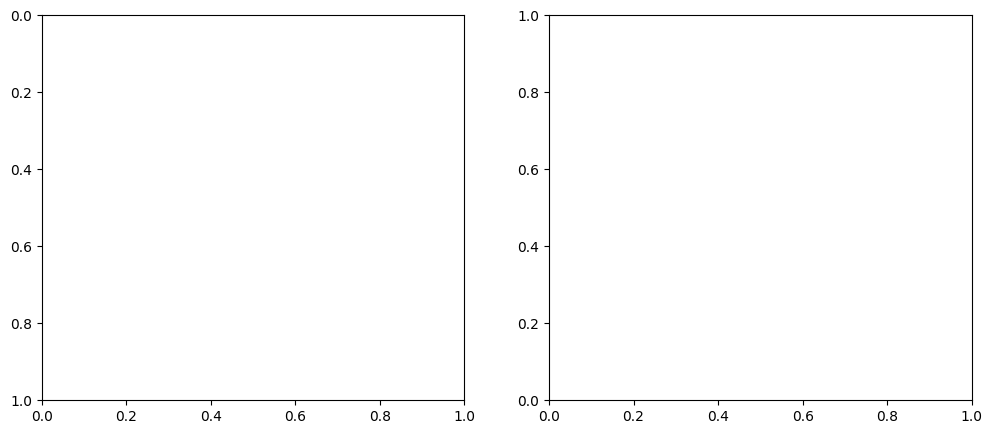

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
sns.lineplot(x=np.arange(len(loss_5)), y=loss_5, label='5 Local Epochs', ax=axs[0])
sns.lineplot(x=np.arange(len(loss_10)), y=loss_10, label='10 Local Epochs', ax=axs[0])
sns.lineplot(x=np.arange(len(loss_20)), y=loss_20, label='20 Local Epochs', ax=axs[0])
axs[0].set_ylabel('Validation Loss')
axs[0].set_title('Validation Loss vs. Global Round (IID Data)')

sns.lineplot(x=np.arange(len(acc_5)), y=acc_5, label='5 Local Epochs', ax=axs[1])
sns.lineplot(x=np.arange(len(acc_10)), y=acc_10, label='10 Local Epochs', ax=axs[1])
sns.lineplot(x=np.arange(len(acc_20)), y=acc_20, label='20 Local Epochs', ax=axs[1])
axs[1].set_title('Validation Accuracy vs. Global Round (IID Data)')

axs[1].set_ylabel('Validation Accuracy')

plt.tight_layout()
plt.show()



In [23]:
loss_20


array([0.48208296, 0.34055954, 0.2903414 , 0.23755741, 0.22766203,
       0.20508976, 0.18678221, 0.16836986, 0.16387965, 0.15823454],
      dtype=float32)